<div style="width: 100%; clear: both;">
<div style="float: left; width: 50%;">
<img src="https://www.uoc.edu/content/dam/news/images/noticies/2016/202-nova-marca-uoc.jpg", align="left" width="380" height="120">
</div>
</div>
<div style="float: right; width: 50%;">
<p style="margin: 0; padding-top: 22px; text-align:right;">22.520 - Minería de textos</p>
<p style="margin: 0; text-align:right;">Grado en Ciencia de Datos Aplicada</p>
<p style="margin: 0; text-align:right; padding-button: 100px;">Estudios de Informática, Multimedia y Telecomunicaciones</p>
</div>
</div>
<div style="width: 100%; clear: both;">
<div style="width:100%;">&nbsp;</div>


# Procesamiento y análisis de información textual (PRA1)

## Práctica realizada por: ALBERTO RODRÍGUEZ ÁLVAREZ 

En la PRA1 trabajaremos con un dataset de reseñas (opiniones o reviews) y lo analizaremos siguiendo un conjunto de tareas: pasando por la preparación y limpieza de los datos, hasta la evaluación de modelos de clasificación de sentimientos. Por lo tanto, los objetivos de esta actividad son:

- Aplicar técnicas de procesamiento de lenguaje natural para limpiar y preprocesar los datos del dataset elegido.
- Implementar algoritmos de aprendizaje automático, como LDA y clasificación supervisada, para analizar los textos de las reseñas.
- Evaluar el rendimiento de los modelos creados, utilizando las métricas adecuadas

Por tanto, en esta primera práctica, revisaremos y aplicaremos los conocimientos aprendidos en los módulos 2, 3 y 4 de la asignatura. Concretamente trataremos 5 temas.

<ul>
<li>1. Elección y preparación del dataset (10%).
<li>2. Obtención de datos (30%).
<li>3. Detección de temas (30%).
<li>4. Clasificación automática de opiniones positivas y negativas (20%).
<li>5. Evaluación (10%).
</ul>
  
A continuación, se describe la estructura de la práctica a realizar. Considerar que por cada apartado, se han planteado varios ejercicios a resolver; y en algunos pocos casos, se deja la solución para orientar un poco mejor el desarrollo.

In [76]:
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)
%reset -f # Limpiar espacio de nombres

Don't know how to reset  #, please run `%reset?` for details
Don't know how to reset  limpiar, please run `%reset?` for details
Don't know how to reset  espacio, please run `%reset?` for details
Don't know how to reset  de, please run `%reset?` for details
Don't know how to reset  nombres, please run `%reset?` for details


In [77]:
#pip install contractions

In [92]:
#pip install numpy==1.26.4  pyyaml #downgrade
#!pip install kagglehub

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from prettytable import PrettyTable
import gc
import contractions
import string, re
import nltk
from nltk import pos_tag, word_tokenize
from nltk.collocations import *
from bs4 import BeautifulSoup
import string
import os
from nltk.corpus import wordnet as wn
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
from gensim.models import Phrases
from gensim.models.phrases import Phraser

# 1. Elección y preparación del dataset


## 1.1. Descripción y carga del dataset

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 1em;">

<strong>Ejercicio 1.1.1:</strong> En palabras, describir el título del dataset seleccionado, la dirección original (fuente), y una descripción del mismo.

</div>

El dataset seleccionado es *"Rotten Tomatoes movies and critic reviews dataset"*, obtenido de Kaggle ([Enlace](https://www.kaggle.com/datasets/stefanoleone992/rotten-tomatoes-movies-and-critic-reviews-dataset)). En su descripción vemos que este conjunto de datos fue extraído de la web pública Rotten Tomatoes hasta el 31 de octubre de 2020. Contiene información sobre películas, incluidas las reseñas de críticos y las calificaciones de usuarios y críticos. Aunque puede haber pequeñas inconsistencias entre algunos campos debido al proceso de recolección, el dataset permite analizar la relación entre las opiniones de críticos y usuarios, y puede complementarse con otros datasets cinematográficos.

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 1em;">

<strong>Ejercicio 1.1.2:</strong> Carga del dataset y descripción de sus principales características: tamaño, estructura, distribución de clase/rating, distribución de longitudes de texto, exploración preliminar del texto de las opiniones (orientada a descubrir potenciales tareas de limpieza a realizar).

</div>

<b>Importante</b>: En caso de haber elegido un dataset sin una columna que denote el sentimiento de cada texto, pero, sí el rating, en este ejercicio, agregar una nueva columna de sentimiento. Por ejemplo, si tenemos los valores 1 a 5 para rating, podríamos considerar a los valores de 1 y 2, como sentimiento negativo (0), y a los valores 4 y 5 como positivo (1). Por ahora, nos vamos a centrar en la clasificación binaria, por tanto, no es necesario considerar a los valores de sentimiento “neutral” o rating=3




In [79]:

#carga de datos
df = pd.read_csv('data/rotten_tomatoes_critic_reviews.csv')
# por problemas de 'mode.use_inf_as_na' cambiar formato Inf
df.replace([np.inf, -np.inf], np.nan, inplace=True) 

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1130017 entries, 0 to 1130016
Data columns (total 8 columns):
 #   Column                Non-Null Count    Dtype 
---  ------                --------------    ----- 
 0   rotten_tomatoes_link  1130017 non-null  object
 1   critic_name           1111488 non-null  object
 2   top_critic            1130017 non-null  bool  
 3   publisher_name        1130017 non-null  object
 4   review_type           1130017 non-null  object
 5   review_score          824081 non-null   object
 6   review_date           1130017 non-null  object
 7   review_content        1064211 non-null  object
dtypes: bool(1), object(7)
memory usage: 61.4+ MB


In [80]:
print("tamaño del dataset original:", df.shape,"\n")
print("Columnas:", df.columns,"\n")

df.head()

tamaño del dataset original: (1130017, 8) 

Columnas: Index(['rotten_tomatoes_link', 'critic_name', 'top_critic', 'publisher_name',
       'review_type', 'review_score', 'review_date', 'review_content'],
      dtype='object') 


,rotten_tomatoes_link,critic_name,top_critic,publisher_name,review_type,review_score,review_date,review_content
0,m/0814255,Andrew L. Urban,False,Urban Cinefile,Fresh,NaN,2010-02-06,A fantasy adventure that fuses Greek mythology to contemporary American places and values. Anyone around 15 (give or take a couple of years) will thrill to the visual spectacle
1,m/0814255,Louise Keller,False,Urban Cinefile,Fresh,NaN,2010-02-06,"Uma Thurman as Medusa, the gorgon with a coiffure of writhing snakes and stone-inducing hypnotic gaze is one of the highlights of this bewitching fantasy"
2,m/0814255,NaN,False,FILMINK (Australia),Fresh,NaN,2010-02-09,"With a top-notch cast and dazzling special effects, this will tide the teens over until the next Harry Potter instalment."
3,m/0814255,Ben McEachen,False,Sunday Mail (Australia),Fresh,3.5/5,2010-02-09,"Whether audiences will get behind The Lightning Thief is hard to predict. Overall, it's an entertaining introduction to a promising new world -- but will the consuming shadow of Potter be too big to break free of?"
4,m/0814255,Ethan Alter,True,Hollywood Reporter,Rotten,NaN,2010-02-10,"What's really lacking in The Lightning Thief is a genuine sense of wonder, the same thing that brings viewers back to Hogwarts over and over again."


Podemos observar que el conjunto de datos presenta 1.130.017 entradas y 8 variables. No contiene directamente la columna correspondiente con la categoria de 'sentimiento', la cual se creará mediante la variable *review_score*.

A continuación se realiza una breve descripción de las variables objetivo de nuestro estudio: **review_score** y **review_content**.

In [81]:
df.describe()

,rotten_tomatoes_link,critic_name,top_critic,publisher_name,review_type,review_score,review_date,review_content
count,1130017,1111488,1130017,1130017,1130017,824081,1130017,1064211
unique,17712,11108,2,2230,2,814,8015,949181
top,m/star_wars_the_rise_of_skywalker,Emanuel Levy,False,New York Times,Fresh,3/5,2000-01-01,Parental Content Review
freq,992,8173,841481,13293,720210,90273,48019,267


In [82]:
df['review_score'].unique()[:20] 

array([nan, '3.5/5', '1/4', 'B', '3/5', '4/5', '2/4', '2/5', 'C', '2.5/4',
       '3/4', 'C-', '2.75/5', 'B-', '2.5/5', '5.5/10', '1/5', 'C+', 'D+',
       '1.5/4'], dtype=object)

El resultado anterior es una muestra de los posibles *814* valores que tienen las puntuaciones. Como se aprecia es una variable que necesitas mucha limpieza.

In [83]:
# Extraido de los materiales de la asignatura
def words_counter(text):
    if isinstance(text, str):
        return len(text.split())  # Count words
    else:
        return None

C:\Users\alber\AppData\Local\Temp\ipykernel_21672\129636678.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_10.index, y=top_10.values, palette="viridis", edgecolor="black", ax=axes[0])


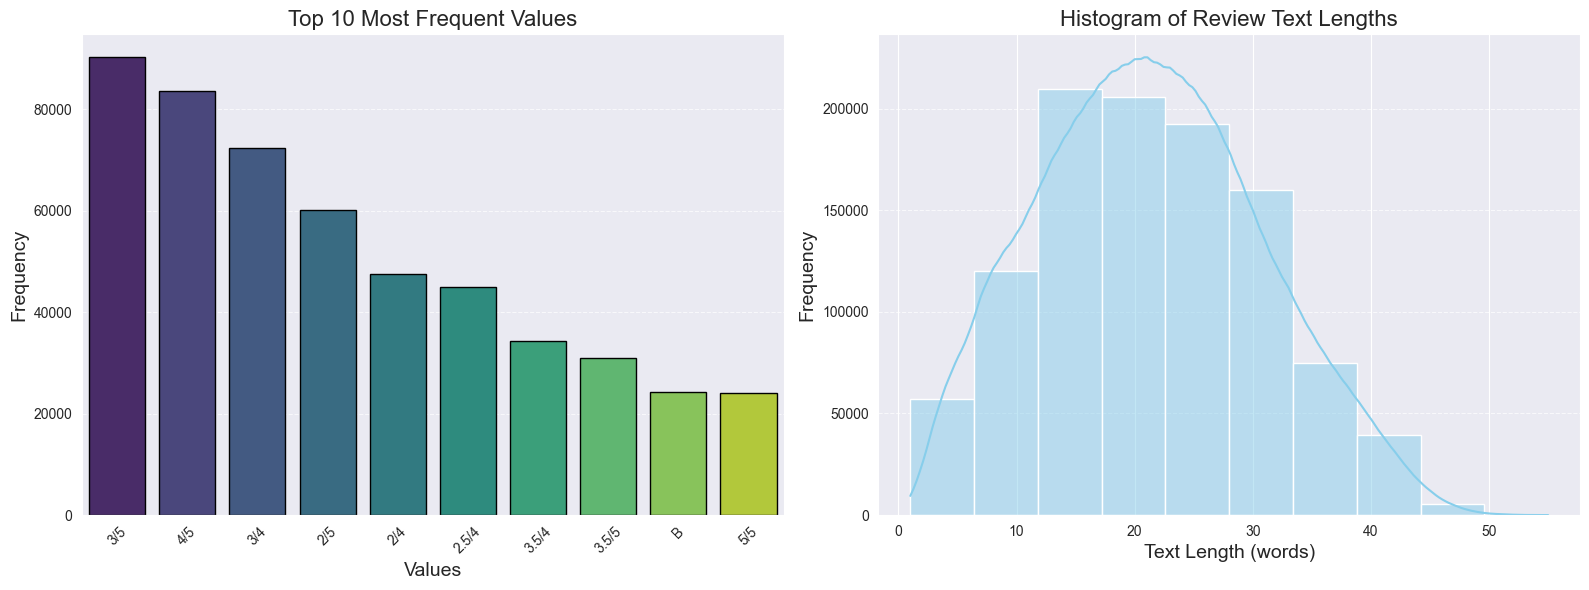

In [84]:
# Frecuencias Puntuaciones
top_10 = df["review_score"].value_counts().head(10) 
# Frecuencias Reseñas
df['length'] = df['review_content'].apply(words_counter)

# Unir gráficas
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

sns.barplot(x=top_10.index, y=top_10.values, palette="viridis", edgecolor="black", ax=axes[0])
axes[0].set_title("Top 10 Most Frequent Values", fontsize=16)
axes[0].set_xlabel("Values", fontsize=14)
axes[0].set_ylabel("Frequency", fontsize=14)
axes[0].tick_params(axis='x', rotation=45)
axes[0].grid(axis="y", linestyle="--", alpha=0.7)

sns.histplot(df['length'], bins=10, kde=True, color="skyblue", ax=axes[1])
axes[1].set_title("Histogram of Review Text Lengths", fontsize=16)
axes[1].set_xlabel("Text Length (words)", fontsize=14)
axes[1].set_ylabel("Frequency", fontsize=14)
axes[1].grid(axis="y", linestyle="--", alpha=0.7)

plt.tight_layout()

plt.show()

Siguiendo el ejemplo aportado junto al enunciado, se procede a seleccionar los datos útiles para el análsis deseado:

In [85]:
#Expandir la visualización de la columna de reseñas:
pd.set_option('display.max_colwidth', 300)

In [86]:
#### review_content
table = PrettyTable()
stats = df['length'].describe()
table.field_names = ["Statistic", "Value"]
for stat_name, value in stats.items():
    table.add_row([stat_name, round(value, 2) if isinstance(value, (int, float)) else value])
print("Descripción previa a la eliminación de reseñas demasiado cortas.\n",table)

Descripción previa a la eliminación de reseñas demasiado cortas.
 +-----------+-----------+
| Statistic |   Value   |
+-----------+-----------+
|   count   | 1064211.0 |
|    mean   |   21.34   |
|    std    |    9.47   |
|    min    |    1.0    |
|    25%    |    14.0   |
|    50%    |    21.0   |
|    75%    |    28.0   |
|    max    |    55.0   |
+-----------+-----------+


In [87]:
df.nsmallest(5, 'length')['review_content']

438     Yabba-dabba-don't.
949             Redundant.
1016            Absorbing.
1444           Ultra-dumb.
2155         Interminable.
Name: review_content, dtype: object

In [88]:
table = PrettyTable()
df_original = df
df = df[df['length'] > 7 ]
stats = df['length'].describe()
table.field_names = ["Statistic", "Value"]
for stat_name, value in stats.items():
    table.add_row([stat_name, round(value, 2) if isinstance(value, (int, float)) else value])
print("Descripción POSTERIOR a la eliminación de reseñas demasiado cortas.\n",table)

Descripción POSTERIOR a la eliminación de reseñas demasiado cortas.
 +-----------+----------+
| Statistic |  Value   |
+-----------+----------+
|   count   | 986859.0 |
|    mean   |  22.61   |
|    std    |   8.62   |
|    min    |   8.0    |
|    25%    |   16.0   |
|    50%    |   22.0   |
|    75%    |   28.0   |
|    max    |   55.0   |
+-----------+----------+


In [89]:
df.nsmallest(5, 'length')['review_content']

61                   Sorry Mr. Jackson, but Harry Potter you ain't.
106                          Not bad, but JK Rowling can rest easy.
146              The Lightning Thief is an admirable kid's fantasy.
217                Touching, intelligent and full of charm and wit.
220    A tremendous leap forward for filmmaker Nicole Holofcener...
Name: review_content, dtype: object

Se han eliminado un total de *773.520* entradas por ser demasiado cortas.

In [90]:
#### review_score
# valores de 1 y 2, como sentimiento negativo (0), y a los valores 4 y 5 como positivo (1). Ignorar neutro (3)
print("Por otro lado, la variable puntuación presenta:",df['review_score'].nunique(),"posibles valores diferentes. Además de",df['review_score'].isna().sum(),"entradas nulas o vacias.")

Por otro lado, la variable puntuación presenta: 784 posibles valores diferentes. Además de 284007 entradas nulas o vacias.


In [91]:
df = df.dropna()

In [92]:
def cambiar_formato_score(value):
    try:
        # Handle percentages explicitly (e.g., "83/100")
        if "/100" in value:
            num, denom = map(float, value.split("/"))
            return max(1, min(5, round((num / denom) * 5)))  # Scale and clamp to 1-5

        # Handle general fractions (e.g., "3.5/5", "4/10")
        if "/" in value:
            num, denom = map(float, value.split("/"))
            return max(1, min(5, round((num / denom) * 5)))  # Scale and clamp to 1-5

        # Handle letter grades, including new cases
        letter_grades = {
            "A": 5, "A-": 5, "A  -": 5,
            "B+": 4, "B": 4, "B-": 4,
            "C+": 3, "C": 3, "C-": 3, "C  -": 3,
            "D+": 2, "D": 2, "D-": 2,
            "F": 1
        }
        if value in letter_grades:
            return letter_grades[value]

        # Handle numeric values directly
        value_float = float(value)
        if value_float > 10:  # Treat as percentage (0-100)
            return max(1, min(5, round((value_float / 100) * 5)))
        else:  # Treat as scale 0-10
            return max(1, min(5, round(value_float / 2)))

    except Exception:
        return np.nan  # Return NaN for invalid or unhandled values


In [93]:
df['sentimiento_1a5'] = df['review_score'].astype(str).apply(cambiar_formato_score)
df[['review_score', 'sentimiento_1a5']].head()

,review_score,sentimiento_1a5
3,3.5/5,4.0
6,1/4,1.0
7,3.5/5,4.0
9,3/5,3.0
10,4/5,4.0


In [94]:
print("La variable puntuación presenta:",df['sentimiento_1a5'].nunique(),"posibles valores diferentes. Además de",df['sentimiento_1a5'].isna().sum(),"entradas nulas o vacias.")

La variable puntuación presenta: 5 posibles valores diferentes. Además de 2 entradas nulas o vacias.


In [95]:
# aplicamos el criterio requerdio creando la variable necesaria SENTIMIENTO
df['sentimiento'] = df['sentimiento_1a5'].map({1: 0, 2: 0, 4: 1, 5: 1, 3: np.nan})
df = df.dropna(subset=['sentimiento'])
df[['review_score', 'sentimiento_1a5', 'sentimiento']].head()

,review_score,sentimiento_1a5,sentimiento
3,3.5/5,4.0,1.0
6,1/4,1.0,0.0
7,3.5/5,4.0,1.0
10,4/5,4.0,1.0
11,2/4,2.0,0.0


In [96]:
data = df[['review_content', 'sentimiento']]
data.head()

,review_content,sentimiento
3,"Whether audiences will get behind The Lightning Thief is hard to predict. Overall, it's an entertaining introduction to a promising new world -- but will the consuming shadow of Potter be too big to break free of?",1.0
6,Harry Potter knockoffs don't come more transparent and slapdash than this wannabe-franchise jumpstarter directed by Chris Columbus.,0.0
7,"Percy Jackson isn't a great movie, but it's a good one, trotting out kernels of Greek mythology like so many Disney Channel references.",1.0
10,"This action-packed fantasy adventure, based on Rick Riordan's hit Percy Jackson and the Olympians series of books, is great fun, and deserves to find an audience with teens now bereft of any Harry Potter magic.",1.0
11,"For what it is and for whom it is intended, it's not a bad movie, just an indifferent one.",0.0


In [97]:
# https://www.hiredevelopers.biz/blog/how-to-delete-a-variable-in-python/#Facilitate_Garbage_Collection_Processes
# liberar memoria
del df

In [98]:
data.head()

,review_content,sentimiento
3,"Whether audiences will get behind The Lightning Thief is hard to predict. Overall, it's an entertaining introduction to a promising new world -- but will the consuming shadow of Potter be too big to break free of?",1.0
6,Harry Potter knockoffs don't come more transparent and slapdash than this wannabe-franchise jumpstarter directed by Chris Columbus.,0.0
7,"Percy Jackson isn't a great movie, but it's a good one, trotting out kernels of Greek mythology like so many Disney Channel references.",1.0
10,"This action-packed fantasy adventure, based on Rick Riordan's hit Percy Jackson and the Olympians series of books, is great fun, and deserves to find an audience with teens now bereft of any Harry Potter magic.",1.0
11,"For what it is and for whom it is intended, it's not a bad movie, just an indifferent one.",0.0


## 1.2 Limpieza de texto

Antes de trabajar con los textos de las reseñas, hay que limpiarlos. En general, dependiendo del dataset podría ser necesario:

1. Eliminar menciones (@), hashtags (#), o código HTML.
2. Eliminar páginas web.
3. Corregir palabras mal escritas (las que resalten en el corpus).
4. Eliminar duplicados.
5. Convertir contracciones, (por ejemplo, en lugar de wouldn't, se cambiaría a would not).
6. Filtrar tokens no alfabéticos.
7. Filtrar signos de puntuación (!) y quitar espacios doble. Se recomienda no quitar el "." porque luego se usará este signo para crear la lista de sentencias. Como referencia ver el ejemplo de PRA proporcionado (*Ejemplo_PRA1.ipynb*).
9. Convertir texto a minúsculas.

Por cada punto, realizar las verificaciones necesarias para determinar la existencia de cada elemento mencionado en el punto anterior (menciones, hashtags, código HTML, páginas web, etc.) e implementar las acciones de limpieza (según se requiera).

<b>IMPORTANTE</b>:
- Antes de implementar cualquier acción, se sugiere crear una columna, llamada *text*, a partir del contenido de la columna de texto original del datset elegido; y sobre la nueva columna aplicar las tareas de limpieza.
- Por cada acción de limpieza realizada, enlistar al menos una reseña que muestre que la función implementada funciona. Es decir, presentar el texto original y el texto transformado (*text*).
- Agregar las celdas de texto y código necesarias, de tal manera que se realice las verificaciones sugeridas, y se dé solución a los problemas de calidad de datos encontrados. Como orientación, se recomienda revisar el archivo <b>Ejemplo_PRA1.ipynb</b> para ver la mejor forma de organanizar la solución.

In [99]:
#Crear la columna 'text' para aplicar en ella las tareas de preprocesamiento y limpieza:
data['text'] = data['review_content'] 
data = data.rename(columns={'review_content': 'reviewText'})
data.head()

,reviewText,sentimiento,text
3,"Whether audiences will get behind The Lightning Thief is hard to predict. Overall, it's an entertaining introduction to a promising new world -- but will the consuming shadow of Potter be too big to break free of?",1.0,"Whether audiences will get behind The Lightning Thief is hard to predict. Overall, it's an entertaining introduction to a promising new world -- but will the consuming shadow of Potter be too big to break free of?"
6,Harry Potter knockoffs don't come more transparent and slapdash than this wannabe-franchise jumpstarter directed by Chris Columbus.,0.0,Harry Potter knockoffs don't come more transparent and slapdash than this wannabe-franchise jumpstarter directed by Chris Columbus.
7,"Percy Jackson isn't a great movie, but it's a good one, trotting out kernels of Greek mythology like so many Disney Channel references.",1.0,"Percy Jackson isn't a great movie, but it's a good one, trotting out kernels of Greek mythology like so many Disney Channel references."
10,"This action-packed fantasy adventure, based on Rick Riordan's hit Percy Jackson and the Olympians series of books, is great fun, and deserves to find an audience with teens now bereft of any Harry Potter magic.",1.0,"This action-packed fantasy adventure, based on Rick Riordan's hit Percy Jackson and the Olympians series of books, is great fun, and deserves to find an audience with teens now bereft of any Harry Potter magic."
11,"For what it is and for whom it is intended, it's not a bad movie, just an indifferent one.",0.0,"For what it is and for whom it is intended, it's not a bad movie, just an indifferent one."


Estilo extraido de 'Ejemplo_PRA1.html' inspeccionar celda.


<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 1em;">

<strong>Ejercicio:</strong>  Eliminar menciones (@)
<br>
<b>Salida esperada:</b> Enlistar una reseña original (*reviewText*), y el texto modificado (*text*).

</div>


In [100]:
# Function to Eliminar menciones (@)
def remove_mentions(text):
    return re.sub(r"@\w+", "", text)

# Aplicar la función a la columna 'text'
data['text'] = data['text'].apply(remove_mentions)
# busca coincidencia e imprime ambas
data.loc[data['reviewText'].str.contains(r"@\w+", na=False)].iloc[0][['reviewText','text']]

reviewText    Pretty #$!@ing funny. Bateman almost out-"Bad Santa"s Billy Bob in this one.
text              Pretty #$! funny. Bateman almost out-"Bad Santa"s Billy Bob in this one.
Name: 159187, dtype: object

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 1em;">
<strong>Ejercicio:</strong> Eliminar hashtags (#)
<br>
<b>Salida esperada:</b> Enlistar una reseña original (reviewText), y el texto modificado (text).

</div>

In [101]:
# Function to eliminar hashtags (#)
def remove_hashtags(text):
    return re.sub(r"#\w+", "", text)

data['text'] = data['text'].apply(remove_hashtags)

# Busca coincidencia e imprime ambas
data.loc[data['reviewText'].str.contains(r"#\w+", na=False)].iloc[0][['reviewText', 'text']]


reviewText    They may as well have called this one 'Mis-Matched Sham Wedding Comedy #57513' for all the effort it makes to shake new life out of a tattered genre.
text                They may as well have called this one 'Mis-Matched Sham Wedding Comedy ' for all the effort it makes to shake new life out of a tattered genre.
Name: 11073, dtype: object

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 1em;">
<strong>Ejercicio:</strong> Eliminar URLs
<br>
<b>Salida esperada:</b> Enlistar una reseña original (reviewText), y el texto modificado (text).

</div>

In [102]:
# Function to eliminar URLs
def remove_urls(text):
    return re.sub(r"http[s]?://\S+", "", text)

def html_links_remove(text):
    soup = BeautifulSoup(text, 'html.parser')
    text = soup.get_text()
    return text

#len(data['reviewText'].apply(remove_urls))
#len(data['reviewText'].apply(lambda x:html_links_remove(x)))
#542886 vs 542886
# mismo resultado con mucha diferencia de coste O()
data['text'] = data['text'].apply(remove_urls)

# Busca coincidencia e imprime ambas
data.loc[data['reviewText'].str.contains(r"http[s]?://\S+", na=False)].iloc[0][['reviewText', 'text']]

#data[data['text'].str.contains("www.", case=False, na=False)]
# Awwww o Me-owwww 

reviewText    Rahim and Arestrup are both so outstanding that if this were an English-language film, they'd probably be nominated for Oscars, too. Read more: http://www.nydailynews.com/entertainment/movies/2010/02/26/2010-02-26_short_takes_a_prophet_art_of_the_steal_y
text                                                                                                                        Rahim and Arestrup are both so outstanding that if this were an English-language film, they'd probably be nominated for Oscars, too. Read more: 
Name: 79388, dtype: object

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 1em;">
<strong>Ejercicio:</strong> Expansión de contracciones
<br>
<b>Salida esperada:</b> Enlistar una reseña original (reviewText), y el texto modificado (text).

</div>

In [103]:
# aplicamos direcctamente contractions
data['text'] = data['text'].apply(lambda x: contractions.fix(x))

ejemplo=data[data['reviewText'].str.contains("don't", case=False, na=False)]
ejemplo[['reviewText','text']].iloc[0]


reviewText     Harry Potter knockoffs don't come more transparent and slapdash than this wannabe-franchise jumpstarter directed by Chris Columbus.
text          Harry Potter knockoffs do not come more transparent and slapdash than this wannabe-franchise jumpstarter directed by Chris Columbus.
Name: 6, dtype: object

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 1em;">
<strong>Ejercicio:</strong>  Quitar ciertos signos de puntación.
<br>
<b>Salida esperada:</b> Enlistar una reseña original (reviewText), y el texto modificado (text).

</div>

In [104]:
punctuation = r';:,!"#$%&()*+-<>@[\\/]^_`…={|}~?'
# /  …  = 
# Función para reemplazar ciertos signos de puntuación:
def clean_signs(text):
    text = re.sub('[%s]' % re.escape(punctuation), ' ', text)
    return text

data['text'] = data['text'].apply(clean_signs)

# Busca coincidencia e imprime ambas
data.loc[data['reviewText'].apply(lambda x: bool(re.search(r"\b[^a-zA-Z\s]+\b", x)))].iloc[0][['reviewText', 'text']]


reviewText     Whether audiences will get behind The Lightning Thief is hard to predict. Overall, it's an entertaining introduction to a promising new world -- but will the consuming shadow of Potter be too big to break free of?
text          Whether audiences will get behind The Lightning Thief is hard to predict. Overall  it is an entertaining introduction to a promising new world    but will the consuming shadow of Potter be too big to break free of 
Name: 3, dtype: object

In [105]:
data.loc[data['reviewText'].str.contains(r">", na=False)].iloc[0][['reviewText', 'text']]


reviewText        Watch a baby for a while and chances are you'll be entertained. Multiply that times four and you have BabiesM/em>, a documentary as funny, charming and un-self-conscious as its subjects.
text          Watch a baby for a while and chances are you will be entertained. Multiply that times four and you have BabiesM them   a documentary as funny  charming and un self conscious as its subjects.
Name: 14320, dtype: object

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 1em;">
<strong>Ejercicio:</strong> Eliminar duplicados
<br>
<b>Salida esperada:</b> Ejemplo de dulpicados, cantidad de duplicados antes y después de la limpieza.

</div>

In [106]:
data[data.duplicated(subset='reviewText')][:3]

,reviewText,sentimiento,text
7757,"Workmanlike at best; derivative, predictable and slightly dull at worst.",0.0,Workmanlike at best derivative predictable and slightly dull at worst.
11168,"Gigantic is the sort of kitchen sink movie many first-time directors make, mistakenly believing that they have to throw every idea they've ever come up with into just one film in case they never get a chance to make another.",0.0,Gigantic is the sort of kitchen sink movie many first time directors make mistakenly believing that they have to throw every idea they have ever come up with into just one film in case they never get a chance to make another.
13594,"The film is visually dazzling, but the main problem is that the script was left of the drawing board. There are endless questions never answered even if one were to ask.",0.0,The film is visually dazzling but the main problem is that the script was left of the drawing board. There are endless questions never answered even if one were to ask.


In [107]:
# Contar duplicados antes y después
duplicates_antes = data.duplicated(subset='text').sum()
data = data.drop_duplicates(subset='text', keep='first')
duplicates_despues = data.duplicated(subset='text').sum()
print("cantidad de duplicados antes",duplicates_antes, "y después de la limpieza",duplicates_despues)

cantidad de duplicados antes 57494 y después de la limpieza 0


<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 1em;">
<strong>Ejercicio:</strong> Convertir texto a minúsculas
<br>
<b>Salida esperada:</b> Enlistar una reseña original (reviewText), y el texto modificado (text).

</div>

In [108]:
# Convertir a minúsculas
data['text'] = data['text'].str.lower()

data.iloc[0][['reviewText', 'text']]

reviewText     Whether audiences will get behind The Lightning Thief is hard to predict. Overall, it's an entertaining introduction to a promising new world -- but will the consuming shadow of Potter be too big to break free of?
text          whether audiences will get behind the lightning thief is hard to predict. overall  it is an entertaining introduction to a promising new world    but will the consuming shadow of potter be too big to break free of 
Name: 3, dtype: object

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 1em;">
<strong>Ejercicio:</strong> Eliminar espacios vacios múltiples
<br>
<b>Salida esperada:</b> Ejemplo manual

</div>

In [109]:
class ExtraSpacesReplacer(object):
    """ Replaces extra spaces in a text.
    >>> replacer = ExtraSpacesReplacer()
    """

    def replace(self, text):
        s = text
        s = re.sub(r'\s\s+', ' ', s)
        return s.strip()

spaces_replacer = ExtraSpacesReplacer()

data['text'] = data['text'].apply(spaces_replacer.replace)

In [110]:
data.loc[data['reviewText'].str.contains('  *', regex=True)].iloc[0][['reviewText', 'text']]

reviewText    Whether audiences will get behind The Lightning Thief is hard to predict. Overall, it's an entertaining introduction to a promising new world -- but will the consuming shadow of Potter be too big to break free of?
text              whether audiences will get behind the lightning thief is hard to predict. overall it is an entertaining introduction to a promising new world but will the consuming shadow of potter be too big to break free of
Name: 3, dtype: object

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 1em;">
<strong>Ejercicio:</strong> Eliminar emoji (1)
<br>
<b>Salida esperada:</b> Enlistar una reseña original (reviewText), y el texto modificado (text).

</div>

In [111]:
def remove_emojis(text):
    return emoji_pattern.sub(r'', text)

emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags=re.UNICODE)

# Aplicar la función a la columna 'text'
data['text'] = data['text'].apply(remove_emojis)
data.loc[data['reviewText'].str.contains(emoji_pattern, na=False)]

,reviewText,sentimiento,text
948949,The Emoji Movie shows how low Hollywood will sink for easy 💰.,0.0,the emoji movie shows how low hollywood will sink for easy .


In [112]:
data[data['text'].str.contains(r"\.\.\.", na=False)].head()

,reviewText,sentimiento,text
37,"Chris Columbus and his crew take a literal approach to spectacle that denies the magnificent use of weirdness and scale that famed stop-action animator Ray Harryhausen brought to such myth-inspired classics as ""Jason and the Argonauts"" (1963)...",1.0,chris columbus and his crew take a literal approach to spectacle that denies the magnificent use of weirdness and scale that famed stop action animator ray harryhausen brought to such myth inspired classics as jason and the argonauts 1963 ...
60,"...great fun for the whole family. And if it introduces you and any young readers in your home to the books, so much the better.",1.0,...great fun for the whole family. and if it introduces you and any young readers in your home to the books so much the better.
85,...an agreeable fantasy adventure that should leave fans of the genre satisfied.,1.0,...an agreeable fantasy adventure that should leave fans of the genre satisfied.
171,"With the romantic notion of the deceased 'haunting' their furniture..., the director at once adds some ethereal spirituality and an earthbound connection between people and their possessions.",1.0,with the romantic notion of the deceased 'haunting' their furniture... the director at once adds some ethereal spirituality and an earthbound connection between people and their possessions.
215,"There are laughs and moments of pain and many instances of embarrassing (and deeply human) behavior throughout, but there's also delicacy and grace...",1.0,there are laughs and moments of pain and many instances of embarrassing and deeply human behavior throughout but there is also delicacy and grace...


<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 1em;">
<strong>Ejercicio:</strong> Eliminar puntos suspensivos (siguiendo el criterio de elimiar ! o ?)
<br>
<b>Salida esperada:</b> Enlistar una reseña original (reviewText), y el texto modificado (text).

</div>

In [113]:

def remove_suspensivos(text):
    # si empieza la frase fuera, sino solo 1
    if text.strip().startswith("..."):
        return re.sub(r"^\.\.\.", "", text).strip()
    else:
        return re.sub(r"\.\.\.", ".", text)

# Aplicar la función a la columna 'text'
data['text'] = data['text'].apply(remove_suspensivos)
data.loc[data['reviewText'].str.contains(r'\.\.\.', regex=True)].iloc[0][['reviewText', 'text']]

reviewText    Chris Columbus and his crew take a literal approach to spectacle that denies the magnificent use of weirdness and scale that famed stop-action animator Ray Harryhausen brought to such myth-inspired classics as "Jason and the Argonauts" (1963)...
text               chris columbus and his crew take a literal approach to spectacle that denies the magnificent use of weirdness and scale that famed stop action animator ray harryhausen brought to such myth inspired classics as jason and the argonauts 1963 .
Name: 37, dtype: object

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 1em;">
<strong>Ejercicio:</strong> Eliminar espacios en blanco normales como tabulaciones (\t) y saltos de línea (\n) al principio y final de la frase
<br>
<b>Salida esperada:</b> Enlistar una reseña original (reviewText), y el texto modificado (text).

</div>

In [114]:
def remove_extra_spaces(text):
    return text.strip()
data['text'] = data['text'].apply(remove_extra_spaces)
data.loc[data['reviewText'].str.contains(r'\s+$', regex=True)].iloc[0][['reviewText', 'text']]

reviewText    The ultimate Depression-era satire of the idle rich and tribute to the noble poor. This popular theme was never more devastatingly realized than in this opening sequence

text           the ultimate depression era satire of the idle rich and tribute to the noble poor. this popular theme was never more devastatingly realized than in this opening sequence
Name: 23914, dtype: object

In [115]:
# data.loc[data['text'].str.contains(r'[^a-zA-Z0-9\s\.]', regex=True)].iloc[143][['reviewText', 'text']]
# dado que implican caracteres especiales, acentos y otras opciones... dejaré solo los a-zA-Z0-9\s\.
data['text'].str.contains(r'[^a-zA-Z0-9\s\.]', regex=True).sum()

np.int64(109508)

data.loc[data['reviewText'].str.contains(r'\.\.\.', regex=True)].iloc[0][['reviewText', 'text']]
< div
style = "background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 1em;" >
< strong > Ejercicio: < / strong > Eliminar todo lo que no sea letra, numero o '.' (punto).
< br >
< b > Salida
esperada: < / b > Enlistar una reseña original (reviewText), y el texto modificado (text).

< / div >

In [121]:
def solo_lo_basico(text):
    """
    Elimina todos los caracteres excepto letras, números y el punto.
    :param text: str, texto de entrada
    :return: str, texto limpio
    """
    return re.sub(r'[^a-zA-Z0-9\. ]', '', text)
data['text'] = data['text'].apply(solo_lo_basico)
data.loc[data['reviewText'].str.contains(r'[^a-zA-Z0-9\s\.]', regex=True)].iloc[1][['reviewText', 'text']]

reviewText     Harry Potter knockoffs don't come more transparent and slapdash than this wannabe-franchise jumpstarter directed by Chris Columbus.
text          harry potter knockoffs do not come more transparent and slapdash than this wannabe franchise jumpstarter directed by chris columbus.
Name: 6, dtype: object

In [117]:
data.sample(n=10, random_state=42)

,reviewText,sentimiento,text
194614,"The filmmaker works with economy and has a knack for creating a sense of foreboding, which is good because the plot is simply a working out of the old saw that violence begets violence.",1.0,the filmmaker works with economy and has a knack for creating a sense of foreboding which is good because the plot is simply a working out of the old saw that violence begets violence.
335671,"Directed by Christian Caron, Farewell is full of great cinematic moments...",1.0,directed by christian caron farewell is full of great cinematic moments.
61885,A fascinating look at this epically tortured artist.,1.0,a fascinating look at this epically tortured artist.
1007179,"Trueba is determined to give every actor, cameraman and grip a few scenes in which to shine, resulting in an overstuffed story that staggers from subplot to subplot.",0.0,trueba is determined to give every actor cameraman and grip a few scenes in which to shine resulting in an overstuffed story that staggers from subplot to subplot.
324507,An exciting but subdued sci-fi thriller about astronauts on a fouled-up mission to find out if there's life on Jupiter.,1.0,an exciting but subdued sci fi thriller about astronauts on a fouled up mission to find out if there is life on jupiter.
1093675,"Perhaps a better celebration of these unfairly dismissed heroes would be a film that isn't this painfully forced, false and fabricated.",0.0,perhaps a better celebration of these unfairly dismissed heroes would be a film that is not this painfully forced false and fabricated.
558467,"One can't help but feel this version of ""Mary Queen of Scots"" could only have been made in a post-Hillary world, fueled by feminist anger searching for validation, for confirmation that men have ruined everything for centuries.",1.0,one cannot help but feel this version of mary queen of scots could only have been made in a post hillary world fueled by feminist anger searching for validation for confirmation that men have ruined everything for centuries.
435775,Routine revenge flick offers little to the genre.,0.0,routine revenge flick offers little to the genre.
202817,"Brad's Status is that rarest of offerings: a brave, smart and occasionally laugh-out-loud film that hits grown-ups right where they live. It provides food for thought and supplication for the soul.",1.0,brads status is that rarest of offerings a brave smart and occasionally laugh out loud film that hits grown ups right where they live. it provides food for thought and supplication for the soul.
307564,"Undercooked, lazy and frustratingly underwhelming despite solid performances.",0.0,undercooked lazy and frustratingly underwhelming despite solid performances.


In [120]:
data.shape

(485392, 3)

In [124]:
data.to_csv('data/ejercicio1.csv', index=False, encoding='utf-8')

In [126]:
df = data.sample(n=10000, random_state=42)
df.to_csv('data/ejercicio1_redux.csv', index=False, encoding='utf-8')

# 2. Obtención de datos

En esta parte analizaremos el texto, *encontraremos el conjunto de términos multipalabra relevantes del dataset y analizaremos el objeto y aspectos de las opiniones* del texto utilizando el modelo Word2Wec. Para ello empezaremos calculando los **mejores bigramas y trigramas de las opiniones del dataset y evaluarlos** según distintas métricas (PMI y Likehood). Posteriormente, detectaremos los **n-gramas que cumplan un patrón sintáctico de un sintagma nominal** (e.g: adjetivo + nombre en singular/plural, nombre + nombre y nombre en singular/plural) y, terminaremos **detectando colocaciones** con un modelo de detección de frases, por ejemplo con el módulo Phraser de Gensim. Una vez analizados los terminos multiplalabra, **crearemos un modelo word2vec** con las opiniones lematizadas y lo utilizaremos para analizar los targets de las opiniones.


In [12]:
# Para este apartado es necesario cargar las siguientes librerías:
import nltk
nltk.download('all')
from nltk import pos_tag, word_tokenize
from nltk.collocations import *

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to
[nltk_data]    |     C:\Users\alber\AppData\Roaming\nltk_data...
[nltk_data]    |   Package abc is already up-to-date!
[nltk_data]    | Downloading package alpino to
[nltk_data]    |     C:\Users\alber\AppData\Roaming\nltk_data...
[nltk_data]    |   Package alpino is already up-to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     C:\Users\alber\AppData\Roaming\nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger is already up-
[nltk_data]    |       to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger_eng to
[nltk_data]    |     C:\Users\alber\AppData\Roaming\nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger_eng is already
[nltk_data]    |       up-to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     C:\Users\alber\AppData\Roaming\nltk_data...
[

In [13]:
#Importar la lista de stopwords en el idioma de los *reviews* de la libreria NLTK y agregamos algunas adicionales:
stopwords =  ["would"]
stopwords = stopwords + nltk.corpus.stopwords.words('english')
stopwords[:15] # extracto de stopwords.

['would',
 'i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your']

### 2.1. Detección de colocaciones

Las colocaciones son términos multipalabra, es decir, secuencias de palabras que, en conjunto, tienen un significado que difiere significativamente del significado de cada palabra individual (e.g."free version").

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 1em;">

<strong>Ejercicio 2.1.1:</strong> Calcular los mejores bigramas y trigramas de las opiniones. De los mejores bigramas y trigramas, elige a los que no comienzan, ni terminan con una stopword.
<br>
<b>Salida esperada:</b> Imprimir los primeros 20 n-grams obtenidos con cada métrica.
</div>
<br>
<b>Pasos a realizar</b>:

-  Obtener los tokens del texto de las opiniones y etiquetarlos por su PoS
-   Aplicar las métricas PMI y Likehood Ratio para calcular los mejores bigramas y los mejores trigramas a partir de los tokens etiquetad ylos que no comcenzan ni terennan con una stopword.

<div style="background-color: #F8F7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
    
<i>Primer paso</i>: Obtener los tokens del texto de las reseñas. Etiqueta estos tokens por su PoS.

Utiliza los métodos *word_tokenize* para tokenizar el texto de las reseñas y  *pos_tag* para determinar la etiqueta de cada token.
<br>
<b>Salida esperada:</b> Imprime los diez primeros tokens, con su respectiva etiqueta:
</div>
<br>

In [131]:
#En las siguientes líneas df es el dataframe donde se cargó el dataset, y text es la columna que tiene el texto preprocesado.
#Se sugiere actualizar la siguiente línea con los objetos propios y correr las instrucciones.
opinions = " ".join(df['text'])
opinions[:251]
#len(opinions)

'the filmmaker works with economy and has a knack for creating a sense of foreboding which is good because the plot is simply a working out of the old saw that violence begets violence. directed by christian caron farewell is full of great cinematic mo'

In [132]:
# SOLUCIÓN PASO 1
tokens = [w for w in word_tokenize(opinions) if w != '.']
# para los n-gramas eliminamos el punto, ahora no importan las frases.

In [133]:
for i, token in enumerate(tokens[:5]):
    print(f"{i}: {token}")

0: the
1: filmmaker
2: works
3: with
4: economy


In [134]:
tagged_tokens = nltk.pos_tag(tokens)
tagged_tokens[:10]

[('the', 'DT'),
 ('filmmaker', 'NN'),
 ('works', 'VBZ'),
 ('with', 'IN'),
 ('economy', 'NN'),
 ('and', 'CC'),
 ('has', 'VBZ'),
 ('a', 'DT'),
 ('knack', 'NN'),
 ('for', 'IN')]


<div style="background-color: #F8F7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
    
<i>Segundo paso</i>: Calcular los 300 mejores bigramas y los 300 mejores trigramas a partir de los tokens etiquetados (e.g. [(we, PRP), ...]) del texto. Utiliza las métricas PMI y Likehood Ratio.
<br>
<b>Condición</b>: De la lista de mejores bigramas y trigramas, elige a los que no comienzan ni terminen con una stopword. Para el filtrado de stopwords considera:
- La lista previamente cargada (desde el paquete NLTK), y
- Las categorías POS que representan a palabras vacías como determinantes, preposiciones, entre otras.
<br>
<b>Salida esperada:</b> Imprime los primeros 20 n-grams obtenidos con cada métrica.
</div>

Recordemos la clasificación de etiquetas PoS.

<b>Etiquetas PoS</b>

<ul>
<li>DT: Determinante</li>
<li>JJ: Adjetivo</li>
<li>NN: Nombre en singular</li>
<li>NNS: Nombre en plural</li>
<li>VBD: Verbo en pasado</li>
<li>VBG: Verbo en gerundio</li>
<li>MD: Verbo modal</li>
<li>IN: Preposición o conjunción subordinada</li>
<li>PRP: Pronombre</li>
<li>RB: Adverbio</li>
<li>RP: Partícula</li>    
<li>CC: Conjunción coordinada</li>
<li>CD: Numeral</li>
</ul>

In [135]:
no_pos_in = ['DT', 'IN', 'PRP', 'CC', 'CD', 'MD', 'VBG', 'VBD', 'RP']
filtered_tokens_pos = [
    (word, pos) for word, pos in tagged_tokens 
    if word not in stopwords and pos not in no_pos_in
]

con el código anterior se garantiza “que no comcenzan ni terennan con una stopword.” como pide el enunciado, así como la condición de elimiar algunos tipos de PoS (Part of Speech) descritos en la variable no_pos_in

In [136]:
filtered_tokens_pos[:10]


[('filmmaker', 'NN'),
 ('works', 'VBZ'),
 ('economy', 'NN'),
 ('knack', 'NN'),
 ('sense', 'NN'),
 ('good', 'JJ'),
 ('plot', 'NN'),
 ('simply', 'RB'),
 ('old', 'JJ'),
 ('saw', 'NN')]

In [137]:
#Cargamos las métricas para el cálculo de bigramas y trigramas:

bigram_measures = nltk.collocations.BigramAssocMeasures()
trigram_measures = nltk.collocations.TrigramAssocMeasures()

#############################################
# SOLUCIÓN PASO 2                           #
#############################################

ngrams_num = 300
words = [word for word, pos in filtered_tokens_pos]  # Extraer solo palabras

# Crear objetos Bigram y Trigram Finder
bigram_finder = BigramCollocationFinder.from_words(words)
trigram_finder = TrigramCollocationFinder.from_words(words)

# Obtener todos los bigramas y trigramas
all_bigrams = list(bigram_finder.ngram_fd.keys())
all_trigrams = list(trigram_finder.ngram_fd.keys())

#bigramas
bigram_pmi = sorted(
    all_bigrams,
    key=lambda x: bigram_finder.score_ngram(bigram_measures.pmi, *x),
    reverse=True)[:20]
bigram_lr = sorted(
    all_bigrams,
    key=lambda x: bigram_finder.score_ngram(bigram_measures.likelihood_ratio, *x),
    reverse=True)[:20]

#trigramas
trigram_pmi = sorted(
    all_trigrams,
    key=lambda x: trigram_finder.score_ngram(trigram_measures.pmi, *x),
    reverse=True)[:20]
trigram_lr = sorted(
    all_trigrams,
    key=lambda x: trigram_finder.score_ngram(trigram_measures.likelihood_ratio, *x),
    reverse=True)[:20]

In [138]:
print("###############\n  Solucion\n###############\n")
print("Top 20 Bigramas por PMI:", bigram_pmi,"\n")
print("Top 20 Trigramas por PMI:", trigram_pmi,"\n")
print("Top 20 Bigramas por Likelihood Ratio:", bigram_lr,"\n")
print("Top 20 Trigramas por Likelihood Ratio:", trigram_lr)

###############
  Solucion
###############

Top 20 Bigramas por PMI: [('cappers', 'obsequious'), ('scherler', 'mayer'), ('tarkovsky', 'bresson'), ('generalization', 'wolfs'), ('gillo', 'pontecorvos'), ('villainous', 'conversely'), ('confirmed', 'initiates'), ('yellows', 'rusts'), ('instils', 'sherpa'), ('sherpa', 'vibrancy'), ('vibrancy', 'reinforced'), ('amassed', 'loyal'), ('tuesday', 'welds'), ('cline', 'sciamma'), ('sciamma', 'gilded'), ('bellyflops', 'abysmally'), ('judges', 'nominal'), ('lina', 'wertmullers'), ('wertmullers', 'eroti'), ('gwyneth', 'paltrows')] 

Top 20 Trigramas por PMI: [('instils', 'sherpa', 'vibrancy'), ('sherpa', 'vibrancy', 'reinforced'), ('cline', 'sciamma', 'gilded'), ('lina', 'wertmullers', 'eroti'), ('bury', 'stench', 'overwhelms'), ('bombed', 'cityscape', 'hurl'), ('cityscape', 'hurl', 'grenades'), ('associada', 'inventiva', 'montagem'), ('mt', 'everest', 'k2'), ('mesmerized', 'turquoise', 'wallpaper'), ('turquoise', 'wallpaper', 'burgundy'), ('hasta', 

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">

<strong>Ejercicio 2.1.2:</strong>  Detectar n-gramas que cumplen el patrón sintáctico de un sintagma nominal (e.g: adjetivo + nombre en singular/plural, nombre + nombre y nombre en singular/plural). Las palabras componentes de cada n-grama deben estar separdaas por un guión "-".
<br>
<b>Salida esperada:</b> Lista de los 20 primeros n-gramas que cumplan el patrón sintáctico especificado, por ejemplo, 'new_york' y 'tourism'.

</div>

In [150]:
# SOLUCIÓN

def detect_ngrams(tagged_tokens, ngram_list):
    ngramas = []
    token_dict = dict(tagged_tokens)

    for ngram in ngram_list:
        # etiquetas x el n-grama
        tags = [token_dict.get(word, None) for word in ngram]

        # Detectar patrones (adjetivo + sustantivo o sustantivo + sustantivo)
        if len(tags) == 2:
            if (tags[0] in ['JJ', 'NN'] and tags[1] in ['NN', 'NNS']):
                ngramas.append("-".join(ngram))
        elif len(tags) == 3:
            if (tags[0] in ['JJ', 'NN'] and tags[1] in ['NN', 'NNS'] and tags[2] in ['NN', 'NNS']):
                ngramas.append("-".join(ngram))
    return ngramas

nominal_bigrams = detect_ngrams(filtered_tokens_pos, all_bigrams)
nominal_trigrams = detect_ngrams(filtered_tokens_pos, all_trigrams)

nominal_ngrams = nominal_bigrams + nominal_trigrams
print("Top 20 nominal n-grams:", nominal_ngrams[:20])

Top 20 nominal n-grams: ['economy-knack', 'knack-sense', 'good-plot', 'old-saw', 'saw-violence', 'violence-begets', 'christian-caron', 'caron-farewell', 'cinematic-moments', 'artist-trueba', 'actor-cameraman', 'cameraman-grip', 'shine-overstuffed', 'overstuffed-story', 'story-staggers', 'subplot-subplot', 'exciting-sci', 'fi-thriller', 'thriller-astronauts', 'life-jupiter']


<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 1em;">

<strong>Ejercicio 2.1.3:</strong> Detectar colocaciones con un modelo de detección de frases, con el módulo Phraser de Gensim. Entrenar el modelo con todas las opiniones.
<br>
</div>
<br>
<b>Pasos a realizar</b>:

1. Crear la lista de sentences. Tomar como referencia el código comentado que consta en la siguiente celda.
2. Convertir las reseñas  en una lista de phrases. Las phrases no deben ser stopwords. Tampoco deben empezar ni acabar con una stopword.
3. Entrenar el modelo con todas las opiniones.


In [17]:
df = pd.read_csv('data/ejercicio1_redux.csv')

In [18]:
#Crear la lista de sentences. Las siguientes líneas pueden ser tomadas como referencia
#Actualizar el nombre del dataframe y de la columna del texto pre-procesado.#
opinions_string = " ".join(df['text'])
opinion_sentences = opinions_string.split('. ')
opinion_sentences[:5]

['the filmmaker works with economy and has a knack for creating a sense of foreboding which is good because the plot is simply a working out of the old saw that violence begets violence',
 'directed by christian caron farewell is full of great cinematic moments',
 'a fascinating look at this epically tortured artist',
 'trueba is determined to give every actor cameraman and grip a few scenes in which to shine resulting in an overstuffed story that staggers from subplot to subplot',
 'an exciting but subdued sci fi thriller about astronauts on a fouled up mission to find out if there is life on jupiter']

<div style="background-color: #F8F7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">

<i>Segundo paso</i>: Convierte las reseñas en una lista de *phrases*. Las phrases no deben ser stopwords. Tampoco deben empezar, ni terminar con una stopword. Utiliza la lista de stopwords para el filtrado.
<br>
<b> Salida esperada:</b> Lista de las 20 primeras *phrases* que no sean, o no contengan stopwords.

</div>

In [36]:
from gensim.models.phrases import Phraser
from gensim.models import Phrases
# SOLUCIÓN PASO 2                           #

tokenized_sentences = [word_tokenize(sentence.lower()) for sentence in opinion_sentences]
# Filtrar stopwords en cada frase tokenizada
stopwords_set = set(stopwords)
filtered_sentences = [
    [word for word in sentence if word not in stopwords_set]
    for sentence in tokenized_sentences
]
# Entrenar el modelo de Phrases
phrases = Phrases(filtered_sentences, min_count=1, threshold=2, delimiter=' ') 
phraser = Phraser(phrases)

# Aplicar el modelo a las frases filtradas
phrased_sentences = [phraser[sentence] for sentence in filtered_sentences]

# NO comienzan o terminan con stopword
final_phrases = []
for sentence in phrased_sentences:
    for phrase in sentence:
        tokens = phrase.split(' ')  # Dividir
        if tokens[0] not in stopwords_set and tokens[-1] not in stopwords_set:
            final_phrases.append(phrase)

print(final_phrases[:20])

['filmmaker', 'works', 'economy', 'knack creating', 'sense', 'foreboding', 'good', 'plot', 'simply', 'working', 'old', 'saw', 'violence', 'begets', 'violence', 'directed', 'christian', 'caron', 'farewell', 'full']


## 2.2 Vectorización de palabras y términos con Word2Vec

Antes de desarrollar los ejercicios, es necesario importar gensim y quitar espacios del texto.

In [37]:
# Importar el paquete gensim, el cual implementa un método para entrenar modelos Word2Vec.

import gensim

#Antes de continuar se sugiere quitar espacios del texto: considerar el siguiente código comentado.
#Considerar que, opinion_phrases_no_stopwords es el objeto generado en el segundo paso del Ejercicio 2.1.3.

opinion_phrases_stripped_no_stopwords = [c.strip() for c in final_phrases]
opinion_phrases_stripped_no_stopwords[:10]

['filmmaker',
 'works',
 'economy',
 'knack creating',
 'sense',
 'foreboding',
 'good',
 'plot',
 'simply',
 'working']



<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">

<strong>Ejercicio 2.2.1:</strong>  Obtener targets de las opiniones y sus aspectos utilizando el modelo Word2vec.
<br>
<b>Salida esperada:</b> Lista de los primeros 15 términos que tengan mayor relación semántica con el término/aspecto seleccionado.
</div>
<br>

Pasos a realizar:
1. Convertir las phrases de cada oración en un token.
2. Crear una sentence stream donde todos los tokens de las oraciones estén lematizados. Los tokens no pueden ser stopwords ni tener un stopword al inicio o al final.
3. Crear un modelo word2vec de las opiniones lematizadas. El modelo debe llamarse w2v_opinions.
4. A partir del vocabulario del modelo word2vec, seleccionar posibles aspectos representativos de la opiniones.

<b><i>Primer paso</i></b>: Convertir las phrases de cada oración en un token. Para completar este paso:

- Concatenar los tokens de la phrase con el caracter '_' (e.g: 'mew york' -> 'new_york').
- En cada oración sustituir los bigramas que son phrases por la forma tokenizada (e.g: This is a one of the best apps acording to a bunch of people and -> This is a one of the best_apps acording to a bunch of people and).
- Al realizar los pasos anteriores, las colocaciones formarán parte del vocabulario del modelo word2vec que generaremos.

<i>Importante:</i> El siguiente código puede ser tomado como referencia para completar este primer paso. Considerar que:

- *opinion_phrases_stripped_no_stopwords* es el objeto creado al iniciar este apartado (2.2).
- *opinion_sentences* es la lista de sentences creada en el primer paso del Ejercicio 2.1.3.

In [50]:
from nltk.util import ngrams

collocation_phrases = [phrase for phrase in list(set(opinion_phrases_stripped_no_stopwords)) if ' ' in phrase]
print(collocation_phrases[9])
def transform_sentence(sentence):
    transformed_sentence = sentence
    n_grams = list(ngrams(nltk.word_tokenize(sentence), 2))
    ngrams_t = [' '.join(gram) for gram in n_grams]
    for ngram in ngrams_t:
        if ngram.lower() in collocation_phrases:
            opt = ngram.replace(' ', '_')
            transformed_sentence = transformed_sentence.replace(ngram,opt)
    return transformed_sentence

opinion_sentences_transformed = [transform_sentence(os) for os in opinion_sentences]
opinion_sentences_transformed[2]

talked years


'a fascinating_look at this epically tortured artist'

<div style="background-color: #F8F7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">

<i>Segundo paso</i>: Crear una sentence stream donde todos los tokens de las oraciones estén lematizados. Los tokens no pueden ser stopwords ni tener un stopword al inicio o al final. Para simplificar la tarea, podemos considerar que el lema de una colocación no cambia y su PoS es 'col'. (e.g: ['We run a top of the line system utilizing Windows 10 Pro']  -> [run', 'top', 'line', 'system', 'utilize', 'window', 'pro]).
<br>
<b> Salida esperada:</b> Lista de los 10 primeros tokens lematizados (que no sean, ni contengan stopwords).

</div>

In [ ]:
#Importar los métodos de la librería NLTK que lematizan según Wordnet
from nltk.stem.wordnet import WordNetLemmatizer
nltk.download('wordnet')

In [53]:
# SOLUCIÓN

#Para obtener el lema, el término debe tener una etiqueta PoS. El formato de la etiqueta PoS de Wordnet es
#distinto de la etiqueta del pos-tagger de NLTK. Así pues usaré el notebook de teoria como guia

# Función para obtener el formato de etiqueta PoS de WordNet
def get_wn_pos(pos):
    if re.match(r'^N', pos):
        wn_pos = 'n'
    elif re.match(r'^V', pos):
        wn_pos = 'v'
    else:
        wn_pos = 'n'  # x defecto sustantivos
    return wn_pos

# Función para lematizar un término
def wnlemmatize(t, postag):
    lemma = ""
    lem = WordNetLemmatizer() 
    if ' ' not in t: 
        lemma = lem.lemmatize(t, get_wn_pos(postag))
    else:  
        lemma = lem.lemmatize(t, 'n')
    return lemma

def process_sentence(sentence):
    tokens = word_tokenize(sentence.lower())
    tagged_tokens = pos_tag(tokens)
    # Lematizar y filtrar stopwords y tokens con '_'
    lemmatized_tokens = [ wnlemmatize(word, tag) for word, tag in tagged_tokens
        if word not in stopwords_set and "_" not in word  ]
    return lemmatized_tokens

# Aplicar a las oraciones transformadas
sentence_stream = [process_sentence(sentence) for sentence in opinion_sentences_transformed]

# Obtener los primeros 10 tokens lematizados
first_10_tokens = [token for sentence in sentence_stream for token in sentence][:10]
first_10_tokens

['filmmaker',
 'work',
 'economy',
 'knack',
 'create',
 'sense',
 'forebode',
 'good',
 'plot',
 'simply']

<div style="background-color: #F8F7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">

<i>Tercer paso</i>: Crear un modelo word2vec de las opiniones lematizadas. El modelo debe llamarse w2v_opinions.
<br>
<b> Salida esperada:</b> Presentar la cantidad de oraciones usadas en el modelo (usa el atributo *corpus_count*).
</div>

In [75]:
# SOLUCIÓN

# utilizar el máximo de cpu posible...
# https://snyk.io/advisor/python/gensim/functions/gensim.models
max_workers = os.cpu_count()
w2v_opinions  = gensim.models.Word2Vec(
        sentence_stream,
        vector_size=150, 
        window=10, 
        min_count= 1, 
        workers= max_workers,
        seed=1 
)

w2v_opinions.corpus_count

12132

<div style="background-color: #F8F7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">

<i>Cuarto paso</i>: A partir del vocabulario del modelo word2vec, seleccionar posibles aspectos de la reseña (e.g: desktop) y lista los términos semánticamente relacionados con estos aspectos según este modelo.
<br>

<b>Salida esperada:</b> Lista los primeros 20 términos que tengan mayor relación semántica con un término relevante del dominio.
</div>

In [87]:
#############################################
# SOLUCIÓN                                   #
#############################################

# Obtener el vocabulario del modelo de opiniones:
#no_pos_in = ['DT', 'IN', 'PRP', 'CC', 'CD', 'MD', 'VBG', 'VBD', 'RP']

phrases_vocabulary = list(w2v_opinions.wv.index_to_key)
voc_pos = nltk.pos_tag(phrases_vocabulary)
filtered_voc_pos = [
    (word, pos) for word, pos in voc_pos 
    if word not in stopwords and pos not in no_pos_in
]
terms_vocabulary = [pv for pv,pos in filtered_voc_pos]
#print(len(phrases_vocabulary),len(terms_vocabulary))

In [122]:
aspectos = ["director", "actors", "soundtrack", "mesa"]
apecto_terms = {}
max_voc = len(w2v_opinions.wv.index_to_key)
# tamaño minimo (optimizar)
filtered_vocab = [word for word in terms_vocabulary if len(word) > 3]

for aspect in aspectos:
    if aspect in w2v_opinions.wv:
        similar_terms = w2v_opinions.wv.most_similar(aspect, topn=max_voc)
        apecto_terms[aspect] = similar_terms  # Guardar los términos relacionados
    else:
        print(aspect,"no esta en el modelo w2v_opinions")

# Ordenar todos los términos por la puntuación de similitud (descendente)
#apecto_terms['soundtrack'][:5] # este aspecto no tiene una distancia tan perfecta...

actors no esta en el modelo w2v_opinions
mesa no esta en el modelo w2v_opinions


[('put', 0.9980438351631165),
 ('level', 0.998043417930603),
 ('love', 0.9980353116989136),
 ('script', 0.9980303645133972),
 ('cinema', 0.9980277419090271)]

In [128]:
# SALIDA SOLUCION

#df = pd.DataFrame.from_dict(apecto_terms)
df = pd.DataFrame([
    {"Aspect": aspect, "Term": term, "Similarity": similarity}
    for aspect, terms in apecto_terms.items()
    for term, similarity in terms ])
df.sort_values(by="Similarity", ascending=False).head(20)

,Aspect,Term,Similarity
0,director,film,0.999966
1,director,even,0.999961
2,director,make,0.999961
3,director,way,0.999960
4,director,performance,0.999960
5,director,work,0.999960
6,director,take,0.999960
7,director,like,0.999957
8,director,time,0.999957
9,director,character,0.999956


# 3. Detección de temas

En esta parte nos dedicaremos a explorar los temas detectados utilizando WordNet y realizaremos la extracción de temas a partir de  LDA.

## 3.1 Exploración de los temas con WordNet

Para acceder a Wordnet, utilizar la librería nltk.

In [95]:
from nltk.corpus import wordnet as wn

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">

<strong>Ejercicio 3.1.1:</strong> Comprobar si, según Wordnet, existen aspectos que están alejados semánticamente del sentido del target, aunque en el modelo word2vec sean similares. Comprobar calculando la similitud de Wu and Palmer entre el sentido de wordnet del término elegido, (i.e 'word.n.01') y algunos de sus aspectos.
<br>
<b> Salida esperada: </b>
<br>
- Lista de dos términos que según *Wordnet* no estén tan cercanos, y su respectivo score de similitud, y
<br>
- Lista de los mismos términos que según el modelo *word2vec* están más cercanos.

</div>

In [138]:
list(apecto_terms)

['director', 'soundtrack']

In [129]:
# SOLUCIÓN
# Término principal
aspecto = aspectos[0] #director
term_principal = wn.synset('director.n.01')
if aspect in apecto_terms:
    w2v_related_terms = apecto_terms[aspect]  # Lista de términos relacionados según Word2Vec
else:
    print(f"El aspecto '{aspect}' no está en el vocabulario.")
    w2v_related_terms = []

In [139]:
# https://stackoverflow.com/questions/49145386/finding-similarity-between-two-words-using-wup-similarity-in-python
terms_and_scores = []
for term, w2v_similarity in w2v_related_terms:
    synsets = wn.synsets(term, pos=wn.NOUN)  # Obtener sentidos como sustantivos en WordNet
    if synsets:
        wn_score = term_principal.wup_similarity(synsets[0])
        if wn_score is not None:  # sin relación
            terms_and_scores.append((term, wn_score, w2v_similarity))

# Filtrar términos que están alejados según WordNet (baja similitud)
distant_terms = sorted(terms_and_scores, key=lambda x: x[1])[:2]  # Los 2 términos más alejados según WordNet


In [141]:
print("Términos alejados según WordNet:")
for term, wn_score, w2v_similarity in distant_terms:
    print(f"Término: {term}, Similaridad Wu and Palmer: {wn_score:.4f}")

print("\nTérminos más cercanos según Word2Vec:")
for term, wn_score, w2v_similarity in distant_terms:
    print(f"Término: {term}, Similaridad Word2Vec: {w2v_similarity:.4f}")

Términos alejados según WordNet:
Término: plague, Similaridad Wu and Palmer: 0.0909
Término: reshuffling, Similaridad Wu and Palmer: 0.0909

Términos más cercanos según Word2Vec:
Término: plague, Similaridad Word2Vec: 0.9611
Término: reshuffling, Similaridad Word2Vec: 0.7811


<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">

<strong>Ejercicio 3.1.2:</strong> Identificar a los términos monopalabra del vocabulario de word2vec que no están en Wordnet. Filtrar a los términos que sean nombres o adjetivos.

Del conjunto de términos identificados, mencionar a:
- Abreviaturas o términos específicos del dominio o expresiones típicas de la jerga tech.<br>

<b>Salida esperada:</b>
<br>
- Cantidad de términos que no constan en *Wordnet*.
- Lista de los 20 primeros terminos monopalabra que no constan en <i>Wordnet</i>.
- Lista de al menos 3 términos de los enlistados que, sean inherentes al vocabulario software.
</div>

In [147]:
terms_not_in_wn = [word for word in phrases_vocabulary if not wn.synsets(word)]
tagged_terms = pos_tag(terms_not_in_wn)
filtered_terms = [word for word, pos in tagged_terms if pos.startswith("NN") or pos.startswith("JJ")]
sin_jerga = [term for term in filtered_terms
                if any(sub in term for sub in ["tech", "app", "dev", "soft", "code", "comp", "sys"]) ]

In [149]:
# SOLUCIÓN
print(f"Cantidad de términos monopalabra que no constan en WordNet: {len(terms_not_in_wn)}")
print("\nLista de los 20 primeros términos monopalabra que no constan en WordNet:")
print(filtered_terms[:20])

print("\nTérminos relacionados con el dominio software:")
print(sin_jerga[:3])  # Mostrar al menos 3 términos relacionados con software

Cantidad de términos monopalabra que no constan en WordNet: 4322

Lista de los 20 primeros términos monopalabra que no constan en WordNet:
['something', 'everything', 'anything', 'anyone', 'others', 'everyone', 'biopic', 'comedic', 'visuals', 'noir', 'cgi', 'que', 'watchable', 'superhero', 'clich', 'towards', 'onscreen', 'overlong', 'um', 'pre']

Términos relacionados con el dominio software:
['devito', 'capper', 'app']


## 3.2. LDA

Este apartado tiene como objetivo comparar distintos modelos LDA y elegir el más adecuado de forma justificada.

<b>Pasos a seguir:</b>

1. Convertir las opiniones transformadas en listas de nombres y colocaciones.
2. Extraer temas a partir de las listas de nombres y colocaciones de cada oración transformada. Elegir 3 de los mejores experimentos, según el parámetro *num_topics*, y presentar los resultados. Asigna nombres a los temas encontrados.
3. Utilizar la librería pyLDAvis para visualizar los tópicos del mejor modelo que encontraste.

<i>Primer paso</i>: Convertir las opiniones transformadas (opinion_sentences_transformed) en listas de nombres y colocaciones. Esto es necesario ya que los nombres y las colocaciones expresan los temas de las opiniones (e.g: [['This is a one of the best_apps according to the people opinions'] -> ['one', 'best_apps', 'according', 'people', 'opinion'].

<b>Importante:</b> El siguiente código puede ser tomado como referencia para implementar este primer paso:

- opinion_sentences_transformed es el objeto creado en el primer paso del Ejercicio 2.2.1.

In [150]:
lem = WordNetLemmatizer()
def get_noun_and_collocation(sentence):
    nouns_and_collocations = []
    noun_tags = ['NN', 'NNS']
    tokens_pos_tagged = pos_tag(word_tokenize(sentence))
    for tpos in tokens_pos_tagged:
        lemma = lem.lemmatize(tpos[0]).lower()
        if '_' in lemma:
            nouns_and_collocations.append(lemma)
        elif tpos[1] in noun_tags and tpos[0] not in stopwords:
            nouns_and_collocations.append(lemma)
    return nouns_and_collocations

noun_and_collocation_stream = [get_noun_and_collocation(opinion) for opinion in opinion_sentences_transformed]

noun_and_collocation_stream[:15]


[['filmmaker',
  'economy',
  'knack',
  'sense',
  'plot',
  'saw',
  'violence',
  'begets',
  'violence'],
 ['caron', 'farewell', 'moment'],
 ['fascinating_look', 'artist'],
 ['trueba',
  'actor',
  'cameraman',
  'grip',
  'scene',
  'story',
  'stagger',
  'subplot'],
 ['exciting', 'sci_fi', 'thriller', 'astronaut', 'mission', 'life', 'jupiter'],
 ['celebration', 'hero', 'film'],
 ['version',
  'queen',
  'scot',
  'post',
  'world',
  'anger',
  'validation',
  'confirmation',
  'men',
  'everything',
  'century'],
 ['revenge_flick', 'offers_little', 'genre'],
 ['brads_status', 'rarest', 'offering', 'film', 'grown_ups_right'],
 ['food', 'thought', 'supplication', 'soul'],
 ['lazy', 'despite_solid_performances'],
 ['sharon_stone',
  'basic_instinct',
  'moment',
  'film',
  'femme_fatale',
  'warrior',
  'lab',
  'play',
  'part'],
 ['breezy',
  'celebration',
  'career',
  'artist',
  'cleverness',
  'panache',
  'dishonesty',
  'note'],
 ['director',
  'joe',
  'dante',
  'simpl

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">

<strong>Ejercicio 3.2.1:</strong> Extraer temas a partir de las listas de nombres y colocaciones de cada oración transformada. Además, utiliza la librería pyLDAvis para visualizar los tópicos del mejor modelo que encontraste.

<b>Salida esperada:</b>
- De 3 de los mejores experimentos, y por cada uno, imprime las 10 palabras que más se destaquen de cada tópico.
- Visualización del mejor experimento, usando pyLDAvis.

</div>


In [151]:
# Referencias : https://towardsdatascience.com/end-to-end-topic-modeling-in-python-latent-dirichlet-allocation-lda-35ce4ed6b3e0
#           https://stackoverflow.com/questions/15067734/lda-model-generates-different-topics-everytime-i-train-on-the-same-corpus
#           https://github.com/KenHBS/LDA_thesis
#Experimento 1: con n1 tópicos:

# SOLUCIÓN

import gensim.corpora as corpora

# Función para identificar términos nominales del Notebook
def isnp(t):
    if ' ' in t: return True
    elif not wn.synsets(t): return True
    try:
        wn.synset(t + '.n.01')
        return True
    except:
        return False

# Obtener términos nominales de cada oración
def get_nominals(sentence):
    return [np for np in sentence if np in terms_vocabulary and isnp(np)]

# Procesar las oraciones transformadas
nps_in_sentences = [get_nominals(ts) for ts in noun_and_collocation_stream if len(get_nominals(ts)) > 0]

In [154]:
nps_in_sentences[:3]

[['filmmaker', 'economy', 'knack', 'sense', 'plot', 'violence', 'violence'],
 ['caron', 'farewell', 'moment'],
 ['artist']]

In [155]:
# Crear diccionario y corpus
dictionary = corpora.Dictionary(nps_in_sentences)
corpus = [dictionary.doc2bow(text) for text in nps_in_sentences]

# Función para entrenar un modelo LDA
def train_lda(num_topics):
    return gensim.models.LdaModel(
        corpus=corpus,
        id2word=dictionary,
        num_topics=num_topics,
        random_state=42,
        passes=20,
        alpha='auto'
    )

# Entrenar tres modelos con diferentes valores de num_topics
lda_models = {
    # como se indica en el foro
    f"lda_{n}": train_lda(num_topics=n) for n in [5, 8, 10]
}

In [161]:
# Mostrar los tópicos formateados como texto tal como se muestra en los notebooks
for name, model in lda_models.items():
    print(f"\nModelo {name}:")
    for topic in model.show_topics(num_topics=-1, num_words=10, formatted=True):
        print(topic)



Modelo lda_5:
(0, '0.063*"film" + 0.019*"character" + 0.019*"story" + 0.017*"time" + 0.014*"way" + 0.013*"life" + 0.012*"performance" + 0.010*"director" + 0.009*"audience" + 0.009*"people"')
(1, '0.026*"comedy" + 0.018*"thing" + 0.015*"actor" + 0.015*"script" + 0.008*"anything" + 0.007*"direction" + 0.007*"hand" + 0.006*"detail" + 0.006*"theme" + 0.005*"case"')
(2, '0.111*"movie" + 0.012*"fun" + 0.009*"kid" + 0.008*"horror" + 0.007*"kind" + 0.006*"show" + 0.006*"effect" + 0.006*"truth" + 0.006*"issue" + 0.006*"question"')
(3, '0.019*"part" + 0.009*"book" + 0.008*"joke" + 0.007*"mind" + 0.007*"word" + 0.006*"adaptation" + 0.005*"thanks" + 0.005*"soul" + 0.004*"lead" + 0.004*"insight"')
(4, '0.026*"year" + 0.016*"thriller" + 0.011*"series" + 0.010*"experience" + 0.007*"anyone" + 0.007*"guy" + 0.006*"minute" + 0.006*"subject" + 0.006*"charm" + 0.006*"tone"')

Modelo lda_8:
(0, '0.039*"story" + 0.035*"way" + 0.033*"life" + 0.020*"drama" + 0.014*"sense" + 0.012*"humor" + 0.012*"point" + 0.

In [162]:
# con formato
for name, model in lda_models.items():
    print(f"\nModelo {name}:")
    for topic_id, terms in model.show_topics(num_topics=-1, num_words=10, formatted=False):
        words = [word for word, _ in terms]
        print(f"Tópico {topic_id}: {', '.join(words)}")



Modelo lda_5:
Tópico 0: film, character, story, time, way, life, performance, director, audience, people
Tópico 1: comedy, thing, actor, script, anything, direction, hand, detail, theme, case
Tópico 2: movie, fun, kid, horror, kind, show, effect, truth, issue, question
Tópico 3: part, book, joke, mind, word, adaptation, thanks, soul, lead, insight
Tópico 4: year, thriller, series, experience, anyone, guy, minute, subject, charm, tone

Modelo lda_8:
Tópico 0: story, way, life, drama, sense, humor, point, dialogue, viewer, film
Tópico 1: comedy, actor, issue, hand, history, case, head, boy, situation, mr
Tópico 2: movie, look, kid, anything, show, reason, family, truth, adventure, reality
Tópico 3: thing, star, sequel, result, fan, franchise, word, version, book, material
Tópico 4: thriller, place, picture, series, joke, woman, nothing, sex, experience, charm
Tópico 5: year, plot, audience, man, kind, end, work, bit, film, tale
Tópico 6: character, time, something, script, action, film,

Usa la librería pyLDAvis para visualizar los tópicos del mejor modelo encontrado.

Mejor modelo según número de topicos... Referencia https://stackoverflow.com/questions/32313062/what-is-the-best-way-to-obtain-the-optimal-number-of-topics-for-a-lda-model-usin
Calculo de la coherencia:

In [163]:
from gensim.models.coherencemodel import CoherenceModel
# Calcular coherencia para cada modelo
for name, model in lda_models.items():
    coherence_model = CoherenceModel(
        model=model,
        texts=nps_in_sentences,
        dictionary=dictionary,
        coherence='c_v'
    )
    coherence_score = coherence_model.get_coherence()
    print(f"Modelo {name} - Coherencia: {coherence_score:.4f}")


Modelo lda_5 - Coherencia: 0.5378
Modelo lda_8 - Coherencia: 0.4690
Modelo lda_10 - Coherencia: 0.5283


con este resultado sería mejor el modelo lda_5, analizando el número más elevado de tópicos y más específicos del modelo lda_10 podría ponerse en duda cual de los dos es mejor. 

In [165]:
# SOLUCIÓN: Visualizar el mejor modelo

#!pip install pyLDAvis

#Instalar la versión pandas 1.5.3 si usas Google Colab como entorno de ejecución.
#!pip install pandas==1.5.3


pyLDAvis.enable_notebook()
# Preparar visualización para el mejor modelo (10 tópicos)
best_model = lda_models["lda_10"]
lda_visualization = gensimvis.prepare(best_model, corpus, dictionary)

# Mostrar visualización interactiva
pyLDAvis.display(lda_visualization)


[notice] A new release of pip is available: 23.2.1 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [166]:
best_model = lda_models["lda_5"]
lda_visualization = gensimvis.prepare(best_model, corpus, dictionary)

# Mostrar visualización interactiva
pyLDAvis.display(lda_visualization)

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">

<strong>Ejercicio Opcional:</strong> Tomando como base los resultados de cada modelo LDA, calcular las métricas de calidad denominadas perplejidad y coherencia, las cuales están definidas en el paquete gensim.
<br>
Tanto la perplejidad como la coherencia son métricas complementarias. Una perplejidad baja indica que el modelo puede generalizar bien a nuevos datos, mientras que una alta coherencia indica que los temas generados son interpretables y distintos entre sí. Cuando evaluamos el rendimiento de un modelo LDA, se sugiere elegir modelos que evidencien un equilibrio entre ambas métricas.
<br>
Como indica el enunciado este ejercicio es opcional, pero ha sido incorporado en la práctica por sí alguien quiere aprender un poco más el tema. Las métricas mencionadas nos puede ayudar a tener un criterio adicional para elegir el modelo de temas máas apropiado. Para una introducción básica de este tema podrían revisar el siguiente post (https://medium.com/@iqra.bismi/topic-modelling-using-lda-fe81a2a806e0)
<br>
<b>Salida esperada:</b>
<br>
- Valores de coherencia y perplejidad de cada modelo (puedes usar el valor absoluto calculado para una mejor interpretación) de cada uno de los 3 modelos de LDA.

</div>

Previamente se había calculado la coherencia para poder elegir el mejor modelo, pese a ello se realiza este apartado nuevamente.

In [169]:
# SOLUCIÓN

metricas = {}

for name, model in lda_models.items():
    coherence_model = CoherenceModel(
        model=model,
        texts=nps_in_sentences,
        dictionary=dictionary,
        coherence='c_v'
    )
    coherence_score = coherence_model.get_coherence()
    perplexity = model.log_perplexity(corpus)
    metricas[name] = {
        'coherencia': coherence_score,
        'perplejidad': perplexity
    }

In [171]:
print("\nMétricas de Calidad de Modelos LDA:")
for name, scores in metricas.items():
    print("Modelo:", name)
    print("  Coherencia:", round(scores['coherencia'], 4))
    print("  Perplejidad:", round(scores['perplejidad'], 4))
    print("-" * 25)


Métricas de Calidad de Modelos LDA:
Modelo: lda_5
  Coherencia: 0.5378
  Perplejidad: -8.4495
-------------------------
Modelo: lda_8
  Coherencia: 0.469
  Perplejidad: -8.6052
-------------------------
Modelo: lda_10
  Coherencia: 0.5283
  Perplejidad: -8.7229
-------------------------


# 4. Clasificación automática de opiniones positivas y negativas

El objetivo de esta parte será crear un clasificador que permita, dado un texto, identificar la polaridad de su opinión.

## 4.1 Clasificación binaria de sentimientos según Logistic Regression

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Ejercicio 4.1.1:</strong> Crear un clasificador automático de opiniones positivas y negativas.
</div>
<br>

<b>Pasos a seguir:</b>

1. Crear dos listas, una con los textos y otra con las etiquetas de valoración (0 y 1).
2. Vectorizar las opiniones con un vectorizador tf.idf. Usad 'word' como analyzer
3. Preparar el corpus de entrenamiento y evaluación y entrenar al clasificador con Logistic Regression.
4. Utilizar el modelo entrenado para predecir la categoría 1 (positivo) o 0 (negativo) de las opiniones del conjunto de test y mostrar las palabras más informativas para cada categoría.ría.

<div style="background-color: #F8F7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">

<i>Primer paso</i>: Crear dos listas. Una con los textos y otra con las etiquetas de valoración (0 y 1).

<b>Salida esperada:</b> Lista de las 3 primeras opiniones.
</div>

In [179]:
# SOLUCIÓN
#https://www.sciencedirect.com/science/article/pii/S2667305323000911
df = pd.read_csv('data/ejercicio1_redux.csv')
opinions = df['text'].tolist()
labels = df['sentimiento'].tolist()
opinions[:3]

['the filmmaker works with economy and has a knack for creating a sense of foreboding which is good because the plot is simply a working out of the old saw that violence begets violence.',
 'directed by christian caron farewell is full of great cinematic moments.',
 'a fascinating look at this epically tortured artist.']



<div style="background-color: #F8F7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">

<i>Segundo paso</i>: Vectorizar las opiniones con un vectorizador tf.idf. Usar 'word' como analyzer.
<br>

<b>Salida esperada:</b> Imprimir la matriz de los vectores correpsondientes a las primeras 5 opiniones.
</div>

In [181]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(analyzer='word', stop_words='english', max_features=5000)
X = vectorizer.fit_transform(opinions) 

# matriz dispersa xa visualizarla
X_dense = X.toarray()

for i in range(5):
    print(f"Opinión {i+1}: {X_dense[i]}")

Opinión 1: [0. 0. 0. ... 0. 0. 0.]
Opinión 2: [0. 0. 0. ... 0. 0. 0.]
Opinión 3: [0. 0. 0. ... 0. 0. 0.]
Opinión 4: [0. 0. 0. ... 0. 0. 0.]
Opinión 5: [0. 0. 0. ... 0. 0. 0.]


<div style="background-color: #F8F7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">

<i>Tercer paso</i>: Preparar el corpus de entrenamiento y evaluación, y entrenar al clasificador con Logistic Regression.
<br>
<b>Salida esperada:</b> Tiempo de ejecución que conlleva realizar el entrenamiento (fit()).
</div>

In [186]:
# SOLUCIÓN
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import time

X_train, X_test, y_train, y_test = train_test_split(X, labels, test_size=0.2, random_state=42)

# modelo de Logistic Regression
classifier = LogisticRegression() # max o seed...

start_time = time.time()
classifier.fit(X_train, y_train)  # Entrenar el modelo
end_time = time.time()

training_time = end_time - start_time
print(f"Tiempo de ejecución del entrenamiento (fit()): {training_time:.2f} segundos")


Tiempo de ejecución del entrenamiento (fit()): 0.03 segundos


<div style="background-color: #F8F7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">

<i>Cuarto paso</i>: Utilizar el modelo entrenado para predecir la categoría 1 (positivo) o 0 (negativo) de las opiniones del conjunto de test y mostrar las palabras más informativas para cada categoría.
<br>
<b>Salida esperada:</b> Lista de las 10 palabras más informativas de cada categoría.
</div>

In [190]:
# SOLUCIÓN
y_pred = classifier.predict(X_test)
print("\npredicción del corpus test\n")
print(y_pred)


predicción del corpus test

[1. 1. 1. ... 1. 1. 1.]


In [189]:
def most_informative_feature_for_binary_classification(vectorizer, classifier, n=10):

    class_labels = classifier.classes_  # 0 y 1 en este caso
    feature_names = vectorizer.get_feature_names_out()
    
    topn_class0 = sorted(zip(classifier.coef_[0], feature_names))[:n]
    topn_class1 = sorted(zip(classifier.coef_[0], feature_names))[-n:]

    print("\nFEATURES +info :\n")
    
    print("\n10 palabras +info para la clase negativa (0):")
    for coef, feat in topn_class0:
        print(f"Clase {class_labels[0]}: {coef:.4f} - {feat}")

    print("\n10 palabras +info para la clase positiva (1):")
    for coef, feat in reversed(topn_class1):
        print(f"Clase {class_labels[1]}: {coef:.4f} - {feat}")

# Llamar a la función
most_informative_feature_for_binary_classification(vectorizer, classifier)


FEATURES +info :


10 palabras +info para la clase negativa (0):
Clase 0.0: -3.3580 - worst
Clase 0.0: -3.0306 - bad
Clase 0.0: -2.7386 - fails
Clase 0.0: -2.4395 - script
Clase 0.0: -2.3719 - instead
Clase 0.0: -2.3058 - mess
Clase 0.0: -2.2461 - dull
Clase 0.0: -2.1172 - plot
Clase 0.0: -2.0716 - problem
Clase 0.0: -2.0240 - bland

10 palabras +info para la clase positiva (1):
Clase 1.0: 2.3612 - best
Clase 1.0: 2.3310 - rare
Clase 1.0: 2.2981 - entertaining
Clase 1.0: 1.9930 - great
Clase 1.0: 1.9902 - fascinating
Clase 1.0: 1.9743 - classic
Clase 1.0: 1.9709 - performance
Clase 1.0: 1.9615 - perfect
Clase 1.0: 1.8637 - powerful
Clase 1.0: 1.8385 - performances


<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
    
<strong>Ejercicio 4.1.2:</strong> Identificar sobre qué aspectos se hacen valoraciones negativas.
</div>
<br>

<b>Pasos a seguir: </b>

1. Elegir dos palabras más informativas de la categoría 0 y un conjunto de opiniones en las que aparezcan estas palabras. Preprocesar las opiniones quitando los caracteres de salto de línea.
2. Utilizar el diccionario de opiniones (archivo AFINN-111) para extraer la polaridad de cada opinión como la media de los valores de las opinion words del texto.
3. Seleccionar opiniones con polaridad negativa que ejemplifiquen los aspectos peor valorados. Comenta cuáles son estos aspectos.tos

<div style="background-color: #F8F7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">

<i>Primer paso</i>: Elegir dos palabras más informativas de la categoría 0 y un conjunto de opiniones en las que aparezcan estas palabras. Preprocesar las opiniones quitando los caracteres de salto de línea.
<br>
<b>Salida esperada:</b> Lista de las 3 primeras opiniones en las que aparezcan los términos seleccionados.

</div>

In [193]:
# SOLUCIÓN
negative_terms = ["worst", "bad"]
selected_opinions = [
    opinion for opinion in opinions if any(term in opinion.lower() for term in negative_terms)
]
preprocessed_opinions = [opinion.replace("\n", " ").strip() for opinion in selected_opinions]

In [195]:
for i, opinion in enumerate(preprocessed_opinions[:3], 1):
    print(f"Opinión {i}: {opinion}")

Opinión 1: colin farrell is woefully miscast in the lead but that is the least of alexanders problems because the film is a disaster on an epic scale sprawling messy incoherent and an early contender for one of the worst movies of 2005.
Opinión 2: liam neesons late career conversion into a bad ass action hero continues. on it is face the premise sounded dumb but the movie is much more nuanced than the trailer would lead you to believe.
Opinión 3: let us save the hemming and hawing the space between us is terrible. no need to add much else to the sentiment. it is a bad film that you will have a bad time watching. period.


<div style="background-color: #F8F7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">

<i>Segundo paso</i>: Utilizar el diccionario de opiniones (archivo AFINN-111) para extraer la polaridad de cada opinión como la media de los valores de las opinion words del texto.
<br>
<b>Salida esperada:</b> Lista de las 3 primeras opioniones y el respectivo puntaje de polaridad.

</div>

In [197]:
# SOLUCIÓN 
opinion_words_file = 'data/AFINN-111.txt'
opinion_words = []

afinn_dict = {}
with open(opinion_words_file, 'r') as of:
    ol = of.readlines()
    for wo in ol:
        w, o = wo.strip().split('\t')
        afinn_dict[w] = int(o)  # Guardar las puntuaciones en el diccionario
        opinion_words.append(w)


In [199]:
def calculate_polarity(opinion):
    words = opinion.lower().split()
    scores = [afinn_dict.get(word, 0) for word in words if word in opinion_words]
    return sum(scores) / len(scores) if scores else 0

# Calcular la polaridad de las opiniones seleccionadas
polarities = [(opinion, calculate_polarity(opinion)) for opinion in preprocessed_opinions]
negative_polarities = [(op, score) for op, score in polarities if score < 0]

# Mostrar las 3 opiniones con polaridad negativa
print("Opiniones con polaridad negativa:")
for op, score in negative_polarities[:3]: 
    print(f"Opinión: {op}\nPolaridad: {score}\n")

Opiniones con polaridad negativa:
Opinión: colin farrell is woefully miscast in the lead but that is the least of alexanders problems because the film is a disaster on an epic scale sprawling messy incoherent and an early contender for one of the worst movies of 2005.
Polaridad: -2.0

Opinión: liam neesons late career conversion into a bad ass action hero continues. on it is face the premise sounded dumb but the movie is much more nuanced than the trailer would lead you to believe.
Polaridad: -2.0

Opinión: let us save the hemming and hawing the space between us is terrible. no need to add much else to the sentiment. it is a bad film that you will have a bad time watching. period.
Polaridad: -1.25


<div style="background-color: #F8F7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">

<i>Tercer paso:</i> Seleccionar opiniones con polaridad negativa que ejemplifiquen los aspectos peor valorados (utilizar un umbral para seleccionar las peores reseñas). Comenta cuáles son estos aspectos.
<br>
<b>Salida esperada: </b>
<br>
- Lista de las tres primeras opiniones negativas.
<br>
- Respuesta a la pregunta ¿Cuáles son los aspectos peor valorados por los clientes?

</div>

Valor de threshold
Referencia: https://www.sciencedirect.com/science/article/pii/S2666827021000074 
*"in the 3-class dataset, in a perfect case, reviews belong to the neutral class should have a polarity score of 0, a positive polarity score for the positive class, and a negative polarity score for reviews belong to negative class"*

In [201]:
#############################################
# SOLUCIÓN                                  #
#############################################
threshold = -1.5  # Ajustar según el rango de polaridad del corpus

# Filtrar opiniones con polaridad negativa por debajo threshold
worst_reviews = [(op, score) for op, score in negative_polarities if score <= threshold]

# Mostrar las tres primeras opiniones con polaridad negativa máxima
print("Tres primeras opiniones con polaridad negativa max:")
for i, (opinion, score) in enumerate(worst_reviews[:3], 1):
    print(f"Opinión {i} (Polaridad: {score}):")
    print(opinion)
    print("-------")

aspects = []
for opinion, _ in worst_reviews:
    aspects.extend([word for word in opinion.lower().split() if word in opinion_words])

# frecuencia
from collections import Counter
aspect_counts = Counter(aspects)


print("\nAspectos peor valorados:")
for aspect, count in aspect_counts.most_common(5):  # Mostrar los 5 más frecuentes
    print(f"{aspect}: {count} menciones")



Tres primeras opiniones con polaridad negativa max:
Opinión 1 (Polaridad: -2.0):
colin farrell is woefully miscast in the lead but that is the least of alexanders problems because the film is a disaster on an epic scale sprawling messy incoherent and an early contender for one of the worst movies of 2005.
-------
Opinión 2 (Polaridad: -2.0):
liam neesons late career conversion into a bad ass action hero continues. on it is face the premise sounded dumb but the movie is much more nuanced than the trailer would lead you to believe.
-------
Opinión 3 (Polaridad: -3.0):
dave is simply put a bad man and part of the brilliance of harrelsons performance is that he makes us feel for him anyway.
-------

Aspectos peor valorados:
bad: 81 menciones
worst: 25 menciones
badly: 10 menciones
no: 6 menciones
terrible: 4 menciones


# 5. Evaluación: comparación de modelos y discusión de resultados

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">

<strong>Ejercicio 5.1:</strong> Obtén los resultados de las métricas de evaluación del clasificador basado en regresión logística.

<b>Salida esperada: </b> Métricas de redimiento del modelo de regresión logística (por clase).
</div>

In [202]:
#############################################
# SOLUCIÓN MODELO REGRESIÓN LOGÍSTICA              #
#############################################
from sklearn.metrics import classification_report, accuracy_score

print(classification_report(y_test, y_pred, target_names=["Clase 0 (Negativo)", "Clase 1 (Positivo)"]))

                    precision    recall  f1-score   support

Clase 0 (Negativo)       0.75      0.42      0.54       736
Clase 1 (Positivo)       0.73      0.92      0.81      1264

          accuracy                           0.73      2000
         macro avg       0.74      0.67      0.67      2000
      weighted avg       0.74      0.73      0.71      2000


In [204]:
accuracy = accuracy_score(y_test, y_pred)
print(f"Precisión global: {accuracy:.2f}")

Precisión global: 0.73


Interpretación Referencia: https://datascience.stackexchange.com/questions/64441/how-to-interpret-classification-report-of-scikit-learn
https://medium.com/@kitkat73275/logistic-regression-in-classification-beeae8619ba4

La precisión mide qué tan bien el modelo distingue entre clases, mientras que la exhaustividad refleja cuántas instancias reales identifica correctamente. El F1-score combina ambas métricas, siendo útil en casos de clases desbalanceadas. A nivel global, la precisión general indica el porcentaje de predicciones correctas sobre el total de datos, ofreciendo una visión resumida del rendimiento del modelo y su capacidad para cumplir los objetivos esperados.

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">

<strong>Ejercicio 5.2:</strong> Obtener también los resultados de las métricas de evaluación para un clasificador diferente. Por ejemplo, utilizar SVM.
<br>
<b>Salida esperada: </b>
<br>
- Tiempo de ejecución que conlleva realizar el entrenamiento (fit()).
<br>
- Métricas de redimiento del modelo SVM (por clase).
<br>
</div>

In [205]:
#############################################
# SOLUCIÓN MODELO SVM                       #
#https://cienciadedatos.net/documentos/py24-svm-python
# https://qu4nt.github.io/sklearn-doc-es/modules/svm.html
from sklearn.svm import SVC

svm_model = SVC(kernel='linear', random_state=42)

start_time = time.time()
svm_model.fit(X_train, y_train)
end_time = time.time()

# Tiempo de ejecución del entrenamiento
training_time = end_time - start_time
print(f"Tiempo de entrenamiento del clasificador SVM: {training_time:.2f} segundos")

y_pred_svm = svm_model.predict(X_test)

print("\nResultados del Clasificador (SVM):")
print(classification_report(y_test, y_pred_svm, target_names=["Clase 0 (Negativo)", "Clase 1 (Positivo)"]))


Tiempo de entrenamiento del clasificador SVM: 3.15 segundos

Resultados del Clasificador (SVM):
                    precision    recall  f1-score   support

Clase 0 (Negativo)       0.71      0.51      0.59       736
Clase 1 (Positivo)       0.76      0.88      0.81      1264

          accuracy                           0.74      2000
         macro avg       0.73      0.69      0.70      2000
      weighted avg       0.74      0.74      0.73      2000


Las métricas de rendimiento del clasificador SVM se interpretan de la misma manera que en el apartado anterior con regresión logística.